# 과제: 네이버 영화 정보 및 평점 크롤링

- 대상: 예매순 상위 5개의 현재 상영 중인 영화
- 수집할 항목: 영화 제목, 주연배우 3인, 네티즌 평점, 관람객 평점, 기자/평론가 평점, 관람객 별점 리뷰 20건 공감순으로(평점, 작성자닉네임, 리뷰본문)

과제
채점 기준
- 1.모듈화 함수 역할이 명확함
- 2.End to End ( 한 번의 실행으로 모든 작업이 이루어짐
- 3.주석 여부 특히 저장 방식에 대한 것
- 선택 : Scrapy 사용 등

In [1]:
import requests
from bs4 import BeautifulSoup
import re

### 1. 예매순 상위 5개의 현재 상영 중인 영화 가져오기

영화 제목, 주연배우 3인

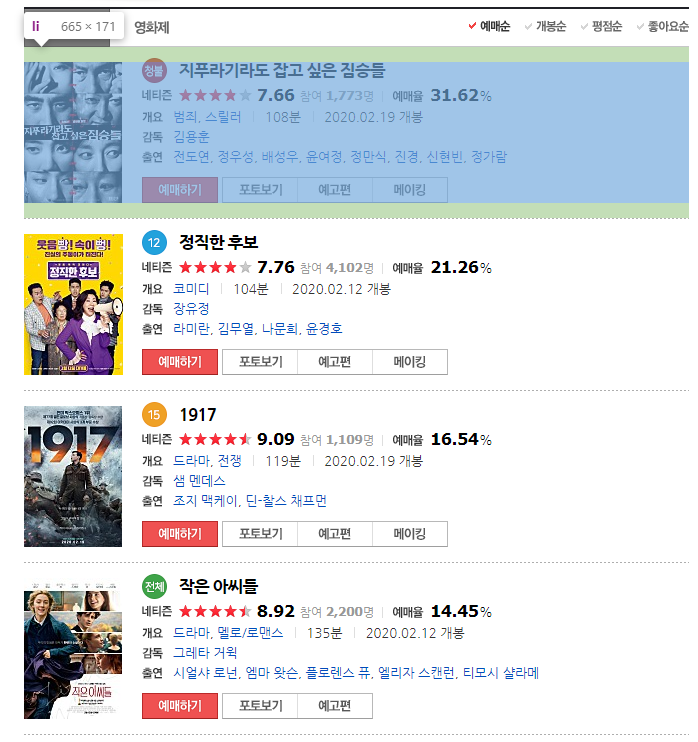

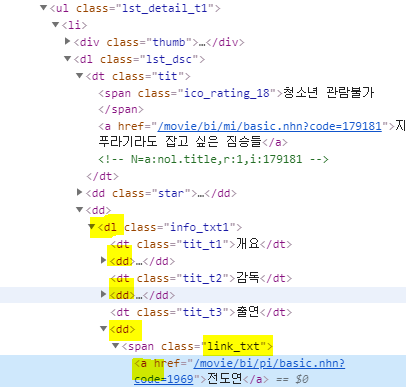

In [2]:
def movie_title_url_actor():
    url = 'https://movie.naver.com/movie/running/current.nhn'
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html,'html.parser')
    
    list = soup.body.find(class_="lst_detail_t1").find_all('li')
    result = []
    for i in range(5):
        title = list[i].find(class_="tit").find("a")
        result.append(title.text)
        #print(title.text)

        # 출연 배우 3명
        try:
            cast = list[i].find("dl", class_="info_txt1").find_all("dd")[2].find(class_="link_txt").find_all("a")
            castList = [cast.text.strip() for cast in cast]
            for i in range(3):
                result.append(castList[i])
                #print(castList[i])
            #print("")
        except IndexError:
            #print(i+1, "번에서 pass")
            if (i == 2):
                result.append(" ")
            elif (i==1):
                result.append(" ")
                result.append(" ")
            pass 
        
        
    final = []
    
    for i in range(5):
        line = []
        line.append(result[i*4])
        line.append(result[i*4+1])
        line.append(result[i*4+2])
        line.append(result[i*4+3])
        final.append(line)

    return final

In [3]:
movie_title_url_actor()

[['지푸라기라도 잡고 싶은 짐승들', '전도연', '정우성', '배성우'],
 ['1917', '조지 맥케이', '딘-찰스 채프먼', ' '],
 ['인비저블맨', '엘리자베스 모스', ' ', ' '],
 ['작은 아씨들', '시얼샤 로넌', '엠마 왓슨', '플로렌스 퓨'],
 ['정직한 후보', '라미란', '김무열', '나문희']]

### 2. 해당 영화의 평점 가져오기

네티즌 평점, 관람객 평점, 기자/평론가 평점 ( 5개씩 가져와보자 )

In [4]:
def get_grade():
    url = 'https://movie.naver.com/movie/running/current.nhn'
    url2 = 'https://movie.naver.com'
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html,'html.parser')
    
    list = soup.body.find(class_="lst_detail_t1").find_all('li')
    result_link = []
    result_s1=[]
    result_s2=[]
    result_s3=[]
    
    result_score = []
    
    # 일단 평점을 볼수 있는 링크를 저장한다.  
    for i in range(5):
        for link in list[i].find(class_="star_t1").find_all('a'):
            result_link.append(url2+link.get('href'))
        #print(result_link[i])

    # 평점
    for i in range(5):
        new_url = result_link[i]   # 이제 새로운 url 은 result_link 가 되었다. 
        res = requests.get(new_url)
        html = res.text
        soup = BeautifulSoup(html,'html.parser')

    # 관람객 평점
        list_1 = soup.body.find(class_="main_score").find(class_="ntz_score").find_all('em')  
        for i in list_1:
            result_s1.append(i.text)   # em 태그에서 하나씩 text를 가져온다.
            
    # 기자/평론가 평점
        list_2 = soup.body.find(class_="main_score").find(class_="star_score").find_all('em')  
        for i in list_2:
            result_s2.append(i.text)   # em 태그에서 하나씩 text를 가져온다.

    # 네티즌 평점
        list_3 = soup.body.find(id = 'pointNetizenPersentBasic').find_all('em')
        for i in list_3:
            result_s3.append(i.text)   # em 태그에서 하나씩 text를 가져온다.
            
    
    # 리스트를 하나의 문자열로 합쳐준다. 
    s1="".join(result_s1)  # 관람객 
    s2="".join(result_s2)  # 기자/평론가
    s3="".join(result_s3)  #네티즌
    
    length=4  # 0.00 형식
    
    s11 = [s1[i:i+length] for i in range(0, len(s1), length)]   # 4글자씩 끊어줌으로써 0.00 형식을 맞추줌,
    s22 = [s2[i:i+length] for i in range(0, len(s2), length)]
    s33 = [s3[i:i+length] for i in range(0, len(s3), length)]
    
    final = []
    
    for i in range(5):
        line = []
        for j in range(1):
            line.append(s11[i])
            line.append(s22[i])
            line.append(s33[i])
        final.append(line)

    return final

In [5]:
get_grade()

[['8.32', '8.32', '6.80'],
 ['9.37', '9.37', '8.98'],
 ['8.67', '8.67', '8.06'],
 ['9.20', '9.20', '8.88'],
 ['8.61', '8.61', '7.71']]

### 3. 관람객 평점 공감순 20건 가져오기

평점, 평점 작성자 닉네임, 리뷰 본문

In [6]:
# !pip install selenium

In [7]:
import selenium.webdriver as webdriver
from urllib.request import Request,urlopen
from time import sleep
import pandas as pd
import re

In [8]:
# URL 입력시 영화 코드 추출
def getCode(URL):
    code_st = re.search('code=[0-9]+',URL).group()
    # 입력된 URL에서 code로 시작해서 숫자로 끝나는 항목을 얻어옴.
    code = re.search('[0-9]+',code_st).group()
    # 입력된 URL에서 숫자 형태로 되어있는 항목을 얻어옴.
    return(code)

In [9]:
def get_reviews():
   # driver = webdriver.Chrome('./chromedriver.exe')
    
    
    url = 'https://movie.naver.com/movie/running/current.nhn'
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html,'html.parser')
    
    # code 와 page에 다른 값이 들어가므로, 앞뒤를 잘라서 준비.
    url1 = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code='
    url2 = '&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page='
    
    list = soup.body.find(class_="lst_detail_t1").find_all('li')
    
    result_link = []  # 영화 하나하나 코드를 찾기위해 링크를 먼저 찾아야겠지요.
    movie_code = []   # movie_code만 따로 저장

    
    # 일단 관람객 평점을 볼수있는 링크에서 코드만 추출한다. 
    for i in range(5):
        for link in list[i].find(class_="star_t1").find_all('a'):
            result_link.append(link.get('href'))

        #print(result_link[i])
        movie_code.append(getCode(result_link[i]))
    #print(movie_code)  # movie code만 따로 저장
    
    
    count =2 # 2페이지까지 접근을 하면 20개 가져올수 있으니까
    URL = [] # 완성된 url을 저장할 list
    page = int(1)
    star= []
    reple = []
    ment = [] 
    
    while count:
        for i in range(5): # 5개의 영화에 대해서 URL 생성
            URL.append(url1+movie_code[i]+url2+str(page))
            open=urlopen(URL[i+(page-1)*5])
            #print(URL)
            html=open.read().decode('utf-8')
            soup = BeautifulSoup(html,"lxml")
            
            list = soup.body.find(class_="score_result").find_all('li')

            
            # 평점
            for i in range(10):
                star.append(list[i].find(class_="star_score").find('em').text)
                reple.append(list[i].find(class_="score_reple").find('em').find('span').text)
                ment.append(list[i].find(class_="score_reple").find('p').text.strip())
                #print(star)     
            
        count -= 1 # count는 감소하고 
        page +=1 # 페이지는 증가하고
            
        if not count: #count ==0 이되면 탈출!
            break
        
    
    result = []

    for i in range(100):
        line = []
        for j in range(1):
            line.append(star[i])
            line.append(reple[i])
            line.append(ment[i])
        result.append(line)
    #print(URL)     
    
    return result

In [10]:
get_reviews()

[['10',
  'bohemian(mabu****)',
  '난 전도연의 화류계 캐릭터가 좋다. 무뢰한, 너는 내 운명, 카운트다운...그리고 지푸라기'],
 ['10', '최정규(cjg4****)', '전도연 연기 진짜 오진다...와 이 영화에서 완전 섹시하게 나온다 역시 명불허전임...'],
 ['10', '달다(fxko****)', '8명의 배우가 모두 주인공 같은 느낌.'],
 ['9', '써니(tlag****)', '개존잼 역시 전도연이죠? 카리스마 미쳐벌여ㅠㅁㅠ'],
 ['10', '까칠소녀(oper****)', '연출, 연기, 스토리 모두 대박...무조건 보세요.'],
 ['9',
  'Cjin(dlck****)',
  '관람객\n\n\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t연기오지고 스릴오지고'],
 ['10', 'trau****', '스토리가 짱짱하네요~ 심리적인 긴장감을 잘 살린 영화인것 같네요~ 인기좀 끌듯...'],
 ['9', 'hojo****', '한국식 피칠갑을 한 타란티노 영화'],
 ['10',
  '꽁끼(bamb****)',
  '관람객\n\n\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t연기 쩐다잉 ,,, 또 보고 싶음 ㅠ'],
 ['9',
  'haeunnnnn(0_80****)',
  '관람객\n\n\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\

### 4. 저장하기

In [11]:
# 1번에 대해서 파일로 저장하기
def save1(data):
    
    test = pd.DataFrame(data, columns=['영화제목','배우1','배우2','배우3'])
    test.to_csv('test1.csv',encoding='cp949')

In [19]:
# 2번에 대해서 파일로 저장하기
def save2(data):
    
    test = pd.DataFrame(data, columns=['관람객','기자','네티즌'])
    test.to_csv('test2.csv',encoding='cp949')

In [20]:
# 3번에 대해서 파일로 저장하기
def save3(data):
    
    test = pd.DataFrame(data, columns=['star','reple','ment'])
    test.to_csv('test3.csv',encoding='cp949')

### 5. 크롤링하기

In [15]:
data1 = movie_title_url_actor()

In [16]:
save1(data1)

In [21]:
data2 = get_grade()

In [22]:
save2(data2)

In [23]:
data3 = get_reviews()

In [24]:
save3(data3)